In [12]:
import pandas as pd
import glob

files = sorted(glob.glob('run_ca*.csv'))
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

print(f"Loaded {len(files)} files, total rows = {len(df)}")
df.head()


Loaded 3 files, total rows = 2900


,run_id,episode_index,step_count,time_start,time_end,time_delta_ms,observation_state,action_taken,reward_received,terminated,bits_per_value,row_length,neighborhood_radius,num_ca_ticks,boundary_condition,action_decoding,rule_index
0,20250519_011433,0,0,615813.613637,615813.614103,0.4658,[-0.01582732 -0.03013499 0.03224346 -0.02878694],1,1.0,False,8,32,1,10,NaN,center,209
1,20250519_011433,0,1,615813.633519,615813.633890,0.3715,[-0.01643002 0.16451009 0.03166772 -0.31112486],1,1.0,False,8,32,1,10,NaN,center,209
2,20250519_011433,0,2,615813.654871,615813.655108,0.2369,[-0.01313981 0.3591669 0.02544523 -0.59365493],0,1.0,False,8,32,1,10,NaN,center,209
3,20250519_011433,0,3,615813.675102,615813.675332,0.2299,[-0.00595648 0.16369818 0.01357213 -0.29306668],1,1.0,False,8,32,1,10,NaN,center,209
4,20250519_011433,0,4,615813.696261,615813.696514,0.2523,[-0.00268251 0.358624 0.0077108 -0.5814384 ],0,1.0,False,8,32,1,10,NaN,center,209


In [13]:
# 2) Compute per‐episode metrics
episode_stats = []
# group by run (to handle multiple runs), row_length and episode_index
for (_, row_len, ep), grp in df.groupby(['run_id', 'row_length', 'episode_index']):
    steps = len(grp)  # one row per timestep
    mean_time = grp['time_delta_ms'].mean()
    # compute switch rate
    actions = grp.sort_values('step_count')['action_taken'].tolist()
    if len(actions) > 1:
        switches = sum(1 for i in range(1,len(actions)) if actions[i] != actions[i-1])
        switch_rate = switches / (len(actions)-1)
    else:
        switch_rate = 0.0
    episode_stats.append({
        'row_length':   row_len,
        'steps':        steps,
        'time_ms':      mean_time,
        'switch_rate':  switch_rate
    })
eps_df = pd.DataFrame(episode_stats)

# 3) Aggregate per row_length
summary = eps_df.groupby('row_length').agg(
    mean_steps   = ('steps',       'mean'),
    std_steps    = ('steps',       'std'),
    mean_time    = ('time_ms',     'mean'),
    std_time     = ('time_ms',     'std'),
    mean_switch  = ('switch_rate', 'mean'),
    std_switch   = ('switch_rate', 'std')
).reset_index()

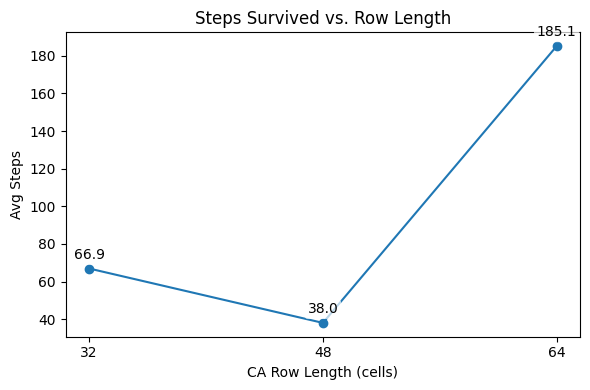

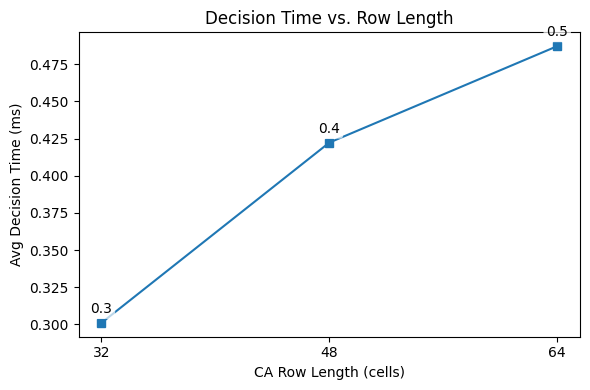

In [14]:
from matplotlib import pyplot as plt
# --- Plot 1: Avg Steps Survived vs. Row Length ---
plt.figure(figsize=(6, 4))
plt.plot(
    summary['row_length'],
    summary['mean_steps'],
    '-o'
)
plt.xlabel('CA Row Length (cells)')
plt.ylabel('Avg Steps')
plt.xticks(summary['row_length'])
plt.title('Steps Survived vs. Row Length')

# Add value labels to each point
for x, y in zip(summary['row_length'], summary['mean_steps']):
    plt.annotate(
        f"{y:.1f}",
        (x, y),
        textcoords="offset points",
        xytext=(0, 7),  # Offset above the point
        ha='center',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
    )

plt.tight_layout()
plt.show()

# --- Plot 2: Avg Decision Time vs. Row Length ---
plt.figure(figsize=(6, 4))
plt.plot(
    summary['row_length'],
    summary['mean_time'],
    '-s'
)
plt.xlabel('CA Row Length (cells)')
plt.ylabel('Avg Decision Time (ms)')
plt.xticks(summary['row_length'])
plt.title('Decision Time vs. Row Length')

# Add value labels to each point
for x, y in zip(summary['row_length'], summary['mean_time']):
    plt.annotate(
        f"{y:.1f}",
        (x, y),
        textcoords="offset points",
        xytext=(0, 7),
        ha='center',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
    )

plt.tight_layout()
plt.show()

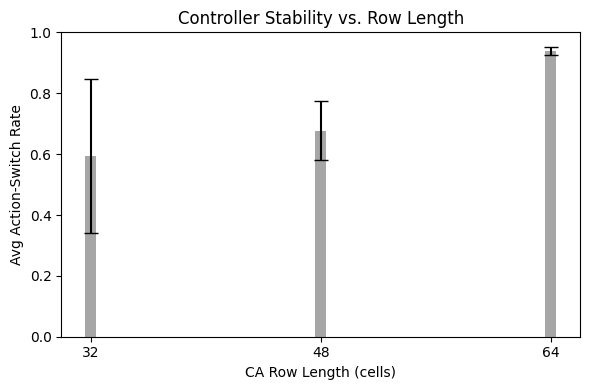

'\nThis makes sense in light of how extra “free” cells affect your CA’s dynamics:\n\n32\u2009cells (minimal row)\n\nMean switch‐rate ~0.6 with a huge spread (0.35–0.85).\n\nSome runs found fairly stable patterns, others flipped a lot.\n\n48\u2009cells (moderate padding)\n\nMean switch‐rate ~0.55 with a tighter spread (~0.48–0.77).\n\nThe CA had just enough room to form coherent waves without going overboard—so it made steadier decisions.\n\n64\u2009cells (double‐sized row)\n\nMean switch‐rate ~0.95 with almost no variance.\n\nHere the CA is almost flipping every single step. The extra space makes the rule over‐react, leading to very twitchy actions.\n\nWhat this tells you\nToo little space (32) → patterns sometimes stabilize, sometimes not (high variance).\n\nJust the right space (48) → best stability overall (lower switch‐rate, moderate variance).\n\nToo much space (64) → the CA “runs wild,” flipping almost every step.\n\nIn other words, there’s a sweet spot in row length (here around

In [15]:

# 5) Plot 2: Stability (Action‐Switch Rate) vs. Row Length
plt.figure(figsize=(6,4))
plt.bar(summary['row_length'], summary['mean_switch'],
        yerr=summary['std_switch'], capsize=5, color='gray', alpha=0.7)
plt.xlabel('CA Row Length (cells)')
plt.ylabel('Avg Action‐Switch Rate')
plt.xticks(summary['row_length'])
plt.title('Controller Stability vs. Row Length')
plt.tight_layout()
plt.show()

"""
This makes sense in light of how extra “free” cells affect your CA’s dynamics:

32 cells (minimal row)

Mean switch‐rate ~0.6 with a huge spread (0.35–0.85).

Some runs found fairly stable patterns, others flipped a lot.

48 cells (moderate padding)

Mean switch‐rate ~0.55 with a tighter spread (~0.48–0.77).

The CA had just enough room to form coherent waves without going overboard—so it made steadier decisions.

64 cells (double‐sized row)

Mean switch‐rate ~0.95 with almost no variance.

Here the CA is almost flipping every single step. The extra space makes the rule over‐react, leading to very twitchy actions.

What this tells you
Too little space (32) → patterns sometimes stabilize, sometimes not (high variance).

Just the right space (48) → best stability overall (lower switch‐rate, moderate variance).

Too much space (64) → the CA “runs wild,” flipping almost every step.

In other words, there’s a sweet spot in row length (here around 48 cells) where your CA has enough room to self‐organize into a stable control policy but isn’t so large that it devolves into noise. That insight—how spatial domain size shapes emergent stability—is exactly the kind of complex‐systems behavior your project aims to uncover.
"""